In [1]:
#%load_ext autotime
import hanford.paths
import yaml
import os
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sdfs.geom_mrst import GeomMRST
from sdfs.bc_mrst import BCMRST
from sdfs.darcy import DarcyExp
from sdfs.tpfa import TPFA
from sdfs.dasa import DASAExpLM, DASAExpLMWithFlux, DASAExpLMScalar
from time import perf_counter
import ckli.mapest as mapest
import ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    #fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = 1e-4
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
res_fac = 1
resolution = '4x'
resolution_ref = '1x'
resolution_iYobs = '4x'
lsq_method = 'trf'
run_MAP = True
geom_filename = f'hanford_data/geom_{resolution}.mat'
geom_ref_filename= f'hanford_data/geom_{resolution_ref}.mat'
bc_filename = f'hanford_data/bc_{resolution}.mat'
conduct_filename = f'hanford_data/conduct_log_{resolution_ref}.mat'
well_cells_filename = f'hanford_data/well_cells_{resolution}.mat'
yobs_filename = f'hanford_data/yobs_{NYobs}_{resolution_iYobs}.npy'
geom_fine_filename = f'hanford_data/geom_{resolution_iYobs}.mat'
ref = f'Yref=orig_interpolated'

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
if resolution_ref != resolution:
    geom_ref = GeomMRST(geom_ref_filename)
else:
    geom_ref = geom
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]
patches_ref = [mpatches.Polygon(v, closed=True) for v in geom_ref.nodes.coords.T[geom_ref.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref_orig = f.get('conduct_log')[:].ravel() - Yfac

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
geom_fine = GeomMRST(geom_fine_filename)

if os.path.exists(yobs_filename):
    print(f'reading {yobs_filename}')
    iYobs_fine = np.load(yobs_filename)[0]
    print(iYobs_fine.size)
#    iYobs_fine = np.load(yobs_filename)
#    if iYobs_fine.ndim != 1:
#        iYobs_fine = iYobs_fine[0]
else:
    print("iYobs randomly generated")
    iYobs_fine = rs.choice(geom_fine.cells.num, NYobs, replace=False)

iYobs_ref = geom_ref.cellsContain(geom_fine.cells.centroids.T[iYobs_fine])
iYobs = geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine])
iYlearn = iYobs_ref
Ylearn = Yref_orig[iYlearn]

reading hanford_data/yobs_100_4x.npy
100


In [9]:
klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
mYlearn = GPy.models.GPRegression(geom_ref.cells.centroids[:,iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
mYlearn.optimize(messages=True, ipython_notebook=False)
mYref = GPy.models.GPRegression(geom_ref.cells.centroids.T, Yref_orig[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
Yref, CYref = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   2.223756e+02   3.415938e+04 
    00s08  0017   1.683999e+02   7.452364e-08 
Runtime:     00s08
Optimization status: Converged



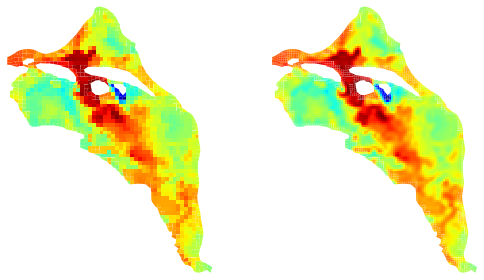

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_patch(patches_ref, Yref_orig + Yfac, fig, ax[0], None, 'Yref', 0, 12)
plot_patch(patches, Yref + Yfac, fig, ax[1], None, 'Yref_4x', 0, 12)
fig.tight_layout()
fig.savefig(f'hanford/figures/Yref/Yref_{resolution_ref=}_NY={NYobs}_{resolution}.pdf', dpi=300)

In [11]:
# Reference pressure field
prob = DarcyExp(TPFA(geom, bc), None)
uref = prob.solve(Yref)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

In [12]:
exp = f'NY={NYobs}_Nu={iuobs.size}_NYlearn={NYlearn}_Nuxi={Nuxi}_NYxi={NYxi}_beta={beta_ckli}_gamma={ugamma_ckli}_h1reg_{ref}'
print(exp)

NY=100_Nu=408_NYlearn=100_Nuxi=1000_NYxi=1000_beta=10.0_gamma=0.0001_h1reg_Yref=orig_interpolated


In [13]:
timings = np.zeros(6)
nfevs = np.zeros(3, dtype=int)
rel_errors = np.zeros(4)
abs_errors = np.zeros(4)

iYlearn = iYobs
Ylearn = Yref[iYlearn]
Yobs = Yref[iYobs]

In [14]:
ts = perf_counter()
klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
mYlearn = GPy.models.GPRegression(geom.cells.centroids[:,iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
mYlearn.optimize(messages=True, ipython_notebook=False)
mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs].T, Yobs[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
Ypred, CYpred = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
timings[0] = perf_counter() - ts

print(f"GPR: {timings[0] : g} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0006   1.787255e+02   8.059418e+02 
    00s09  0018   1.602083e+02   6.876014e-14 
Runtime:     00s09
Optimization status: Converged

GPR:  2.78495 s


In [15]:
# Compute GP model for u
ts = perf_counter()
umean, Cu = ckliest.smc_gp(Ypred, CYpred, Nens, prob, rs)
upred, Cupred = ckliest.gpr(umean, Cu, uobs, iuobs)
timings[1] = perf_counter() - ts

print(f"Monte Carlo: {timings[1] : g} s")

Monte Carlo:  133.144 s


In [16]:
# PICKLE models
Ym = Ypred
CYm = CYpred
um = umean #or change to upred
Cum = Cu #or change to Cupred

rel_errors[0] = rl2e(Ym, Yref)
abs_errors[0] = infe(Ym, Yref)

print(f"Monte Carlo: {timings[1] : g} s")
print(f"GPR\trelative L2 error: {rel_errors[0] : g}")
print(f"GPR\tabsolute infinity error: {abs_errors[0] : g}")

Monte Carlo:  133.144 s
GPR	relative L2 error:  0.51428
GPR	absolute infinity error:  6.46334


In [17]:
ts = perf_counter()
PsiY, LambdaY = ckliest.KL_via_eigh(CYm, NYxi)
Psiu, Lambdau = ckliest.KL_via_eigh(Cum, Nuxi)
timings[2] = perf_counter() - ts

print(f"eigendecomposition: {timings[2] : g} s")

eigendecomposition:  31.9593 s


In [18]:
# PICKLE estimate
Lreg = mapest.compute_Lreg(geom)
ssv = None

res = ckliest.LeastSqRes(NYxi, Ym, PsiY, Nuxi, um, Psiu, prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs, Yobs, beta_ckli, ssv=ssv)
x0 = np.zeros(Nuxi + NYxi)
    
ts = perf_counter()
sol = spo.least_squares(res.val, x0, jac=res.jac, method=lsq_method, verbose=2)
ckli_status = sol.status
timings[3] = perf_counter() - ts
nfevs[0] = sol.nfev
print(f'CKLI optimality: {sol.optimality : g}')

uxi = sol.x[:Nuxi]
Yxi = sol.x[Nuxi:]
uest = um + Psiu @ uxi
Yest = Ym + PsiY @ Yxi

rel_errors[1] = rl2e(Yest, Yref)
abs_errors[1] = infe(Yest, Yref)

print(f"PICKLE: {timings[3] : g} s")
print(f"PICKLE\trelative L2 error: {rel_errors[1] : g}")
print(f"PICKLE\tabsolute infinity error: {abs_errors[1] : g}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4364e+03                                    1.99e+03    
       1              2         1.5638e+03      1.87e+03       1.00e+00       9.65e+02    
       2              3         2.5713e+02      1.31e+03       2.00e+00       1.19e+02    
       3              4         4.3871e+01      2.13e+02       4.00e+00       5.36e+00    
       4              5         8.9352e+00      3.49e+01       8.00e+00       2.64e+01    
       5              6         2.3033e+00      6.63e+00       1.60e+01       9.23e+00    
       6              8         5.6969e-01      1.73e+00       8.00e+00       3.94e+00    
       7              9         5.1601e-01      5.37e-02       1.60e+01       2.82e+01    
       8             10         3.5351e-01      1.63e-01       1.60e+01       8.64e-01    
       9             11         3.3956e-01      1.39e-02       1.34e+01       1.50e+01    

In [19]:
A, B, C, D = res.objectives(uest, Yest)
print(f"{A.T @ A =}, {B.T @ B =}, {C.T @ C =}, {D.T @ D =}")

A.T @ A =0.2934470367703758, B.T @ B =0.08272132486187066, C.T @ C =0.10089375159429126, D.T @ D =0.13891588749623368


In [20]:
A, B, C, D = res.objectives(uref, Yref)
print(f"{A.T @ A =}, {B.T @ B =}, {C.T @ C =}, {D.T @ D =}")

A.T @ A =1.648940003241216e-20, B.T @ B =0.0, C.T @ C =0.1009473006485798, D.T @ D =0.2197559308604875


In [21]:
if run_MAP:
# MAP H1 estimate
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs, Yobs, gamma_map, Lreg) # H1 regularization
    dasa = DASAExpLM(loss.val, loss.grad_u, loss.grad_Y, prob.solve, prob.residual_sens_u, prob.residual_sens_Y)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest_MAPH1 = sol.x

    MAP_status = sol.status
    timings[4] = perf_counter() - ts
    nfevs[1] = sol.nfev
    print(f'MAP status: {MAP_status}, message: {sol.message}')
else:
    Yest_MAPH1 = np.zeros(Nc)
    timings[4] = 0
    nfevs[1] = 0

rel_errors[2] = rl2e(Yest_MAPH1, Yref)
abs_errors[2] = infe(Yest_MAPH1, Yref)

print(f"MAP: {timings[4] : g} s")
print(f"MAP\trelative L2 error: {rel_errors[2] : g}")
print(f"MAP\tabsolute infinity error: {abs_errors[2] : g}")

36e-10       9.82e-04       5.48e-08    
     1027           1061        3.9002e-04      2.33e-10       1.53e-03       1.80e-07    
     1028           1062        3.9002e-04      2.34e-10       9.85e-04       5.58e-08    
     1029           1063        3.9002e-04      2.24e-10       1.46e-03       1.69e-07    
     1030           1064        3.9002e-04      2.28e-10       9.84e-04       5.78e-08    
     1031           1065        3.9002e-04      2.25e-10       1.46e-03       1.67e-07    
     1032           1066        3.9002e-04      2.29e-10       1.00e-03       5.98e-08    
     1033           1067        3.9002e-04      2.23e-10       1.42e-03       1.61e-07    
     1034           1068        3.9002e-04      2.21e-10       9.79e-04       5.91e-08    
     1035           1069        3.9002e-04      2.35e-10       1.52e-03       1.74e-07    
     1036           1070        3.9002e-04      2.33e-10       9.96e-04       5.78e-08    
     1037           1071        3.9002e-04      2

In [22]:
A, B, C, D = res.objectives(prob.solve(Yest_MAPH1), Yest_MAPH1)
print(f"{A.T @ A =}, {B.T @ B =}, {C.T @ C =}, {D.T @ D =}")

A.T @ A =2.1430785394103997e-20, B.T @ B =0.00015660680112829494, C.T @ C =0.09805146333232817, D.T @ D =0.07642408639954713


In [23]:
np.savetxt(f'hanford/results/iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(f'hanford/results/timings/timings_{exp}.txt', timings)
np.savetxt(f'hanford/results/nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(f'hanford/results/rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(f'hanford/results/abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(f'hanford/results/YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(f'hanford/results/YPICKLE/YPICKLE_{exp}.txt', Yest_MAPH1)
np.savetxt(f'hanford/results/YMAP/YMAP_{exp}.txt', Yest_MAPH1)